<a href="https://colab.research.google.com/github/Ayatafoy/color_recognition/blob/master/run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install colormap
!pip install easydev

     |████████████████████████████████| 51kB 2.6MB/s 
  Created wheel for easydev: filename=easydev-0.11.0-cp37-none-any.whl size=64244 sha256=f72f586c2e36d1330604d6f9fd9a3edd973eeaa368309096291fb0d02dca6134
  Stored in directory: /root/.cache/pip/wheels/17/69/b5/771949d8100a30aa33e4bc5d0ff77eced9063284891ce26898
Successfully built easydev


In [34]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import operator
from colormap import rgb2hex
import pickle
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [2]:
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
class fashion_tools(object):
    def __init__(self, imageid, model, version=1.1):
        self.imageid = imageid
        self.model   = model
        self.version = version
        
    def get_dress(self,stack=False):
        """limited to top wear and full body dresses (wild and studio working)"""
        """takes input rgb----> return PNG"""
        name =  self.imageid
        file = cv2.imread(name)
        file = tf.image.resize_with_pad(file,target_height=512,target_width=512)
        rgb  = file.numpy()
        file = np.expand_dims(file,axis=0)/ 255.
        seq = self.model.predict(file)
        seq = seq[3][0,:,:,0]
        seq = np.expand_dims(seq,axis=-1)
        c1x = rgb*seq
        c2x = rgb*(1-seq)
        cfx = c1x+c2x
        dummy = np.ones((rgb.shape[0],rgb.shape[1],1))
        rgbx = np.concatenate((rgb,dummy*255),axis=-1)
        rgbs = np.concatenate((cfx,seq*255.),axis=-1)
        if stack:
            stacked = np.hstack((rgbx,rgbs))
            return stacked
        else:
            return rgbs
        
        
    def get_patch(self):
        return None

In [4]:
saved = load_model("/content/drive/MyDrive/Colab Notebooks/segmentation/Fashion-AI/save_ckp_frozen.h5")

In [5]:
img_name = '/content/drive/MyDrive/Colab Notebooks/segmentation/4.jpg'
api = fashion_tools(img_name, saved)

In [6]:
image = api.get_dress(True)

In [7]:
cv2.imwrite("/content/drive/MyDrive/Colab Notebooks/segmentation/Fashion-AI/4_out.png", image)

True

In [12]:
file = cv2.imread(img_name)
file = tf.image.resize_with_pad(file,target_height=512,target_width=512)
bgr  = file.numpy()
file = np.expand_dims(file,axis=0)/ 255.
seq = saved.predict(file)

In [13]:
seq_new = seq[3][0,:,:,0]
mask = np.where(seq_new > 0.02, 1, 0)

In [14]:
pixels = bgr[:,:,::-1][mask!=0]
bgr[mask==0] = (255,255,255)
bgr = bgr.astype(int)
rgb = bgr[:,:,::-1].copy()

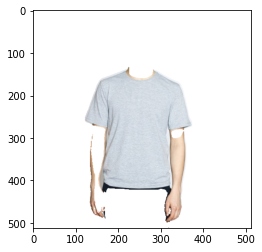

In [15]:
imgplot = plt.imshow(rgb)

In [17]:
with open('/content/drive/MyDrive/Colab Notebooks/segmentation/main_colors_cashe_last.pickle', 'rb') as f:
    main_colors_cashe = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/segmentation/main_color_names_last.pickle', 'rb') as f:
    main_color_names = pickle.load(f)

In [36]:
def calculate_colors(pixels, main_color_names, main_colors_cashe):
    count = 0
    main_stat = {}
    specific_stat = {}
    for name in main_color_names:
        main_stat[name] = 0
    
    
    for i, pixel in enumerate(pixels):
        pixel_hex = rgb2hex(int(pixel[0]), int(pixel[1]), int(pixel[2]))
        main_color_name = main_colors_cashe[pixel_hex]
        main_stat[main_color_name] += 1
        count += 1
    for k, v in main_stat.items():
        main_stat[k] = round(v / count, 2)

    main_stat = sorted(main_stat.items(), key=operator.itemgetter(0))

    return main_stat

In [37]:
result = calculate_colors(pixels, main_color_names, main_colors_cashe)

In [38]:
result

[('beige', 0.1),
 ('black', 0.01),
 ('blue', 0.05),
 ('brown', 0.03),
 ('gray', 0.01),
 ('green', 0.0),
 ('orange', 0.02),
 ('pink', 0.0),
 ('purple', 0.0),
 ('red', 0.0),
 ('silver', 0.05),
 ('white', 0.73),
 ('yellow', 0.0)]